In [1]:
import torch
from torch.nn import CrossEntropyLoss
from braindecode.models import EEGConformer

# Set the torch seed:
torch.manual_seed(0)

# Load Raw preprocessed data
Using the provided scripts

In [2]:
import os
import mne
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

from src.data.utils.eeg import get_raw
from src.data.processing import load_data_dict, get_data
from src.data.conf.eeg_annotations import braincapture_annotations

import logging

# Suppress logger messages from MNE-Python
mne_logger = logging.getLogger('mne')
mne_logger.setLevel(logging.ERROR)

In [3]:
os.chdir("/home/jupyter")
braincapture_data_folder = r'copenhagen_medtech_hackathon/BrainCapture Dataset/'

#data_dict = load_data_dict(data_folder_path=braincapture_data_folder, annotation_dict=braincapture_annotations, tmin=-0.5, tlen=6, labels=True)

In [4]:
X = torch.load("GoogleBrainCaptureHackathon/X_bc_data.pt")
y = torch.load("GoogleBrainCaptureHackathon/y_bc_data.pt")
print('X shape:', X.shape)
print('y shape:', y.shape)

X shape: torch.Size([575, 20, 1537])
y shape: torch.Size([575])


In [5]:
from sklearn.model_selection import train_test_split

X_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=True, stratify=y)

In [6]:
info = mne.create_info(ch_names=20, sfreq=256, ch_types='eeg')

In [7]:
train_epochs = mne.EpochsArray(X_train, info=info)

In [8]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter('runs/experiment_1')

2024-03-16 12:23:53.369862: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
from skorch.dataset import ValidSplit
from braindecode import EEGClassifier
from skorch.callbacks import TensorBoard, Checkpoint
cp = Checkpoint(dirname='checkpoint/', f_params='best_model.pth')
tensorboard = TensorBoard(writer)

# Define the Conformer model:
net = EEGClassifier(
    'ShallowFBCSPNet',
    module__final_conv_length='auto',
    criterion = CrossEntropyLoss(),
    max_epochs=100,
    batch_size=8,
    train_split=ValidSplit(0.15),
    callbacks=[cp],
    optimizer = torch.optim.AdamW,
    optimizer__lr=0.0002, 
    optimizer__betas=(0.5, 0.999),
    device = "cuda",
)

# Start the training procedure:
net.fit(train_epochs, y_train)

/opt/conda/lib/python3.10/site-packages/braindecode/models/base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_loss    valid_acc    valid_loss    cp     dur
-------  ------------  -----------  ------------  ----  ------
      1        2.4556       0.5811        1.0953     +  0.8628
      2        1.8919       0.7297        0.7872     +  0.3356
      3        1.6018       0.7162        0.8795        0.3104
      4        1.5427       0.6892        0.8688        0.3101
      5        1.4656       0.7432        0.7379     +  0.3062
      6        1.3132       0.7838        0.5948     +  0.3162
      7        1.0765       0.7432        0.7853        0.3158
      8        1.2704       0.7838        0.7728        0.3112
      9        1.0948       0.7568        0.6402        0.3151
     10        1.0930       0.7297        0.7688        0.3123
     11        0.9670       0.8243        0.5393     +  0.3085
     12        0.9066       0.7838        0.5607        0.3102
     13        0.9047       0.8108        0.6109        0.3130
     14        0.9520       0.7703        0.7739       

<class 'braindecode.classifier.EEGClassifier'>[initialized](
  module_=============================================================================================================================================
  Layer (type (var_name):depth-idx)        Input Shape               Output Shape              Param #                   Kernel Shape
  ShallowFBCSPNet (ShallowFBCSPNet)        [1, 20, 1537]             [1, 5]                    --                        --
  ├─Ensure4d (ensuredims): 1-1             [1, 20, 1537]             [1, 20, 1537, 1]          --                        --
  ├─Rearrange (dimshuffle): 1-2            [1, 20, 1537, 1]          [1, 1, 1537, 20]          --                        --
  ├─CombinedConv (conv_time_spat): 1-3     [1, 1, 1537, 20]          [1, 40, 1513, 1]          33,040                    --
  ├─BatchNorm2d (bnorm): 1-4               [1, 40, 1513, 1]          [1, 40, 1513, 1]          80                        --
  ├─Expression (conv_nonlin_exp): 

In [10]:
# Define a new classifier:
net_new = EEGClassifier(
    'ShallowFBCSPNet',
    module__final_conv_length='auto',
    module__n_times=1537,
    module__n_chans=20,
    module__n_outputs=5,
    criterion = CrossEntropyLoss(),
    max_epochs=100,
    batch_size=8,
    train_split=ValidSplit(0.15),
    callbacks=[cp],
    optimizer = torch.optim.AdamW,
    optimizer__lr=0.0002, 
    optimizer__betas=(0.5, 0.999),
    device = "cuda",
)

# Initialize it with the parameters of the best checkpoint:
net_new.initialize()
net_new.load_params('checkpoint/params.pt')

/opt/conda/lib/python3.10/site-packages/braindecode/models/base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


In [11]:
test_epochs = mne.EpochsArray(x_test, info=info)

predictions = net_new.predict(test_epochs)

In [12]:
predictions

array([1, 3, 2, 1, 3, 0, 0, 3, 4, 2, 3, 2, 3, 2, 0, 2, 1, 1, 3, 2, 3, 0,
       3, 0, 3, 4, 0, 0, 0, 4, 1, 0, 2, 4, 1, 0, 0, 1, 1, 4, 3, 4, 1, 4,
       2, 4, 3, 0, 1, 2, 3, 0, 0, 3, 2, 1, 0, 1, 3, 4, 3, 1, 4, 2, 4, 3,
       1, 2, 1, 0, 2, 2, 2, 2, 0, 0, 3, 0, 1, 2, 3, 1, 3, 4, 2, 4, 0])

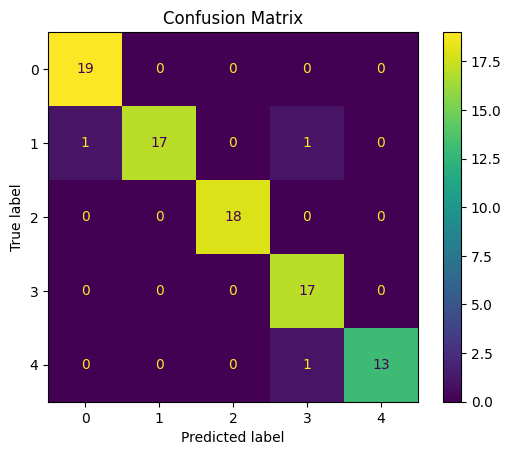

In [35]:
from sklearn.metrics import classification_report, RocCurveDisplay, ConfusionMatrixDisplay, confusion_matrix

predictions = net_new.predict(test_epochs)
cm = confusion_matrix(y_test, predictions, labels=[0,1,2,3,4])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[0,1,2,3,4])

disp.plot()
plt.title('Confusion Matrix')
plt.show()

In [15]:
# predict annotations
probs = np.array(net_new.predict_proba(test_epochs))  # calculate time to just predict one sample

annotations = probs.argmax(axis=-1)

In [16]:
import mne
import numpy as np
import torch
import matplotlib.pyplot as plt
import matplotlib.ticker
import matplotlib.patches as mpatches
import datetime
from src.data.utils.eeg import get_raw
from src.data.processing import normalize_and_add_scaling_channel

def plot_dscnn_annotations(annotations):
    label_dict = {'Eye blinking': 0, 'Eye movement left-right': 1, 'Eyes closed': 2, 'Eyes opened': 3, 'Jaw clenching': 4}
    color_dict = {
        0: np.array([255, 255, 0]),  # yellow
        1: np.array([255, 0, 0]),  # red
        2: np.array([50, 205, 50]),  # lime
        3: np.array([255, 160, 0]),  # orange
        4: np.array([100, 149, 237]),  # cornflowerblue
    }
    names = list(label_dict.keys())
    colors = ['yellow', 'red', 'lime', 'orange', 'cornflowerblue']
    
    annotations_RGB = np.array([color_dict[label] for label in annotations])
    x = np.linspace(0, len(annotations), len(annotations))
    colorsx = [colors[int(item)] for item in annotations]

    fig, ax = plt.subplots(2, 1, figsize=(30, 8))
    ax[0].scatter(x, annotations, c=colorsx, s=100)
    ax[0].set_yticks([0, 1, 2, 3, 4])
    ax[0].set_yticklabels(names, fontsize=24)
    ax[0].set_xlim(0, len(annotations))

    ax[1].imshow(np.expand_dims(annotations_RGB, axis=0), interpolation='nearest', aspect='auto')
    formatter = matplotlib.ticker.FuncFormatter(lambda pos, _: str(datetime.timedelta(seconds=int(pos * 2))))
    
    for i in range(2):
        ax[i].set_xticks(np.linspace(0, len(annotations), 10, dtype=float))
        ax[i].xaxis.set_major_formatter(formatter)
        ax[i].tick_params(axis='x', labelsize=20)

    patches = [mpatches.Patch(color=color, label=name) for color, name in zip(colors, names)]
    ax[0].legend(handles=patches, bbox_to_anchor=(1.05, 1.0), loc='upper left', fontsize=24)
    ax[1].set_yticklabels([])
    plt.suptitle('Predicted Artifacts Labels', size=32)
    plt.show()

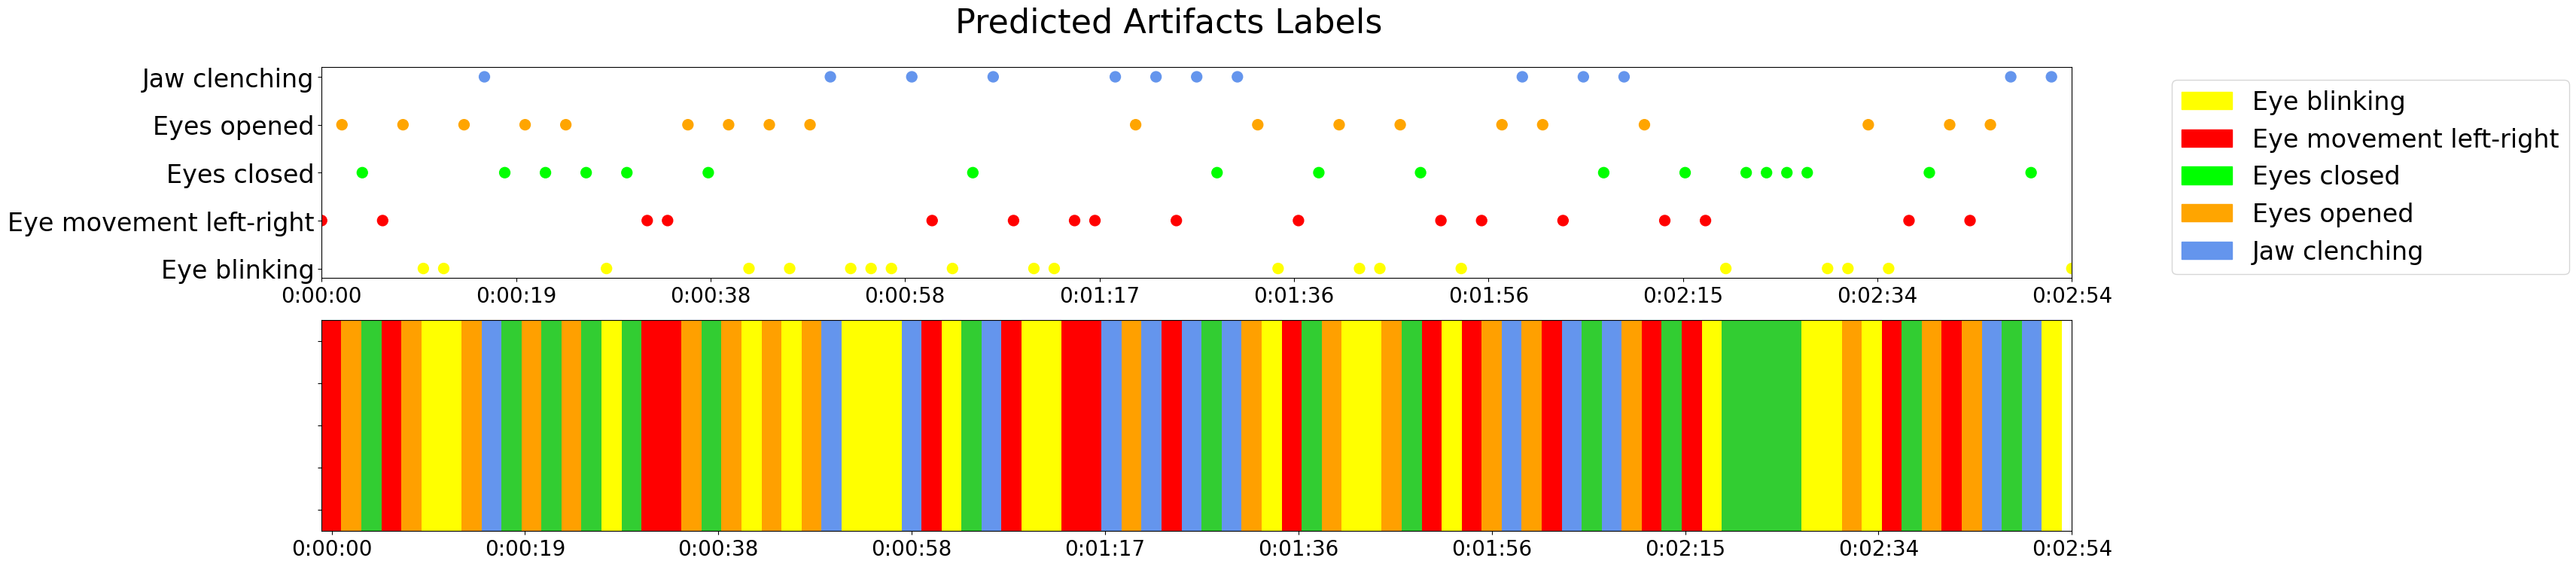

In [17]:
plot_dscnn_annotations(annotations)

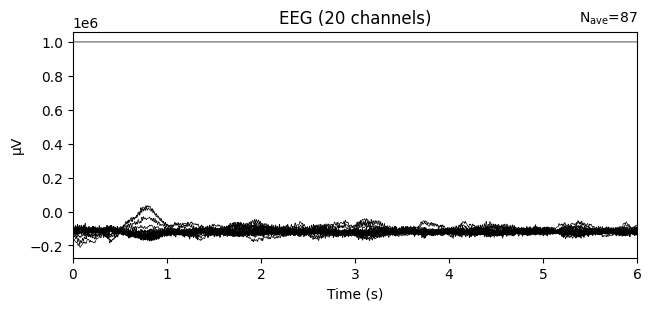

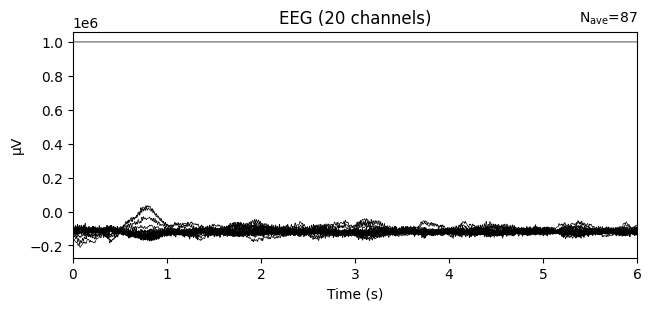

In [19]:
evoked = test_epochs.average()  # Compute average across epochs
evoked.plot()

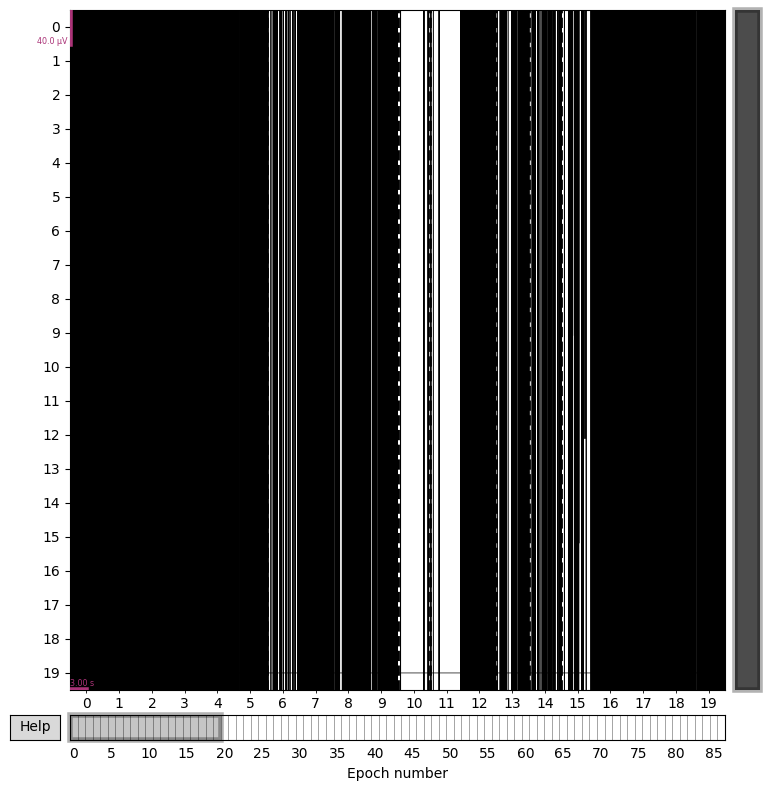

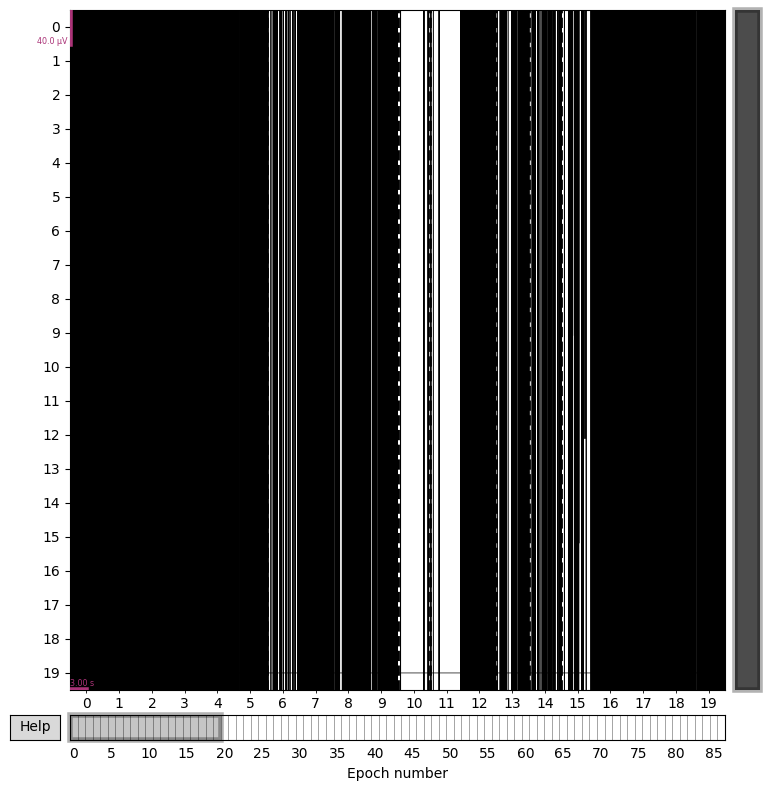

In [20]:
test_epochs.plot(title='Butterfly Plot', picks='eeg')

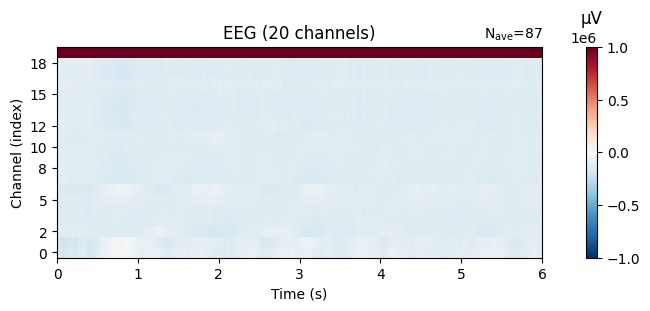

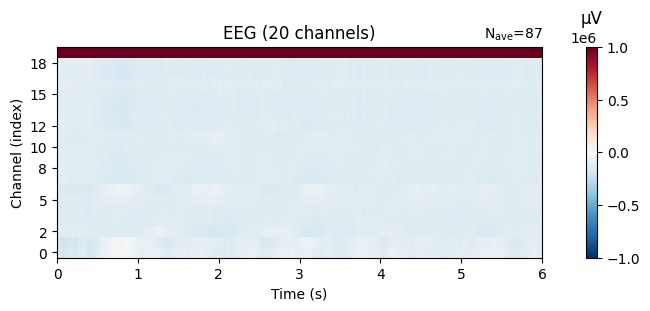

In [21]:
evoked.plot_image()

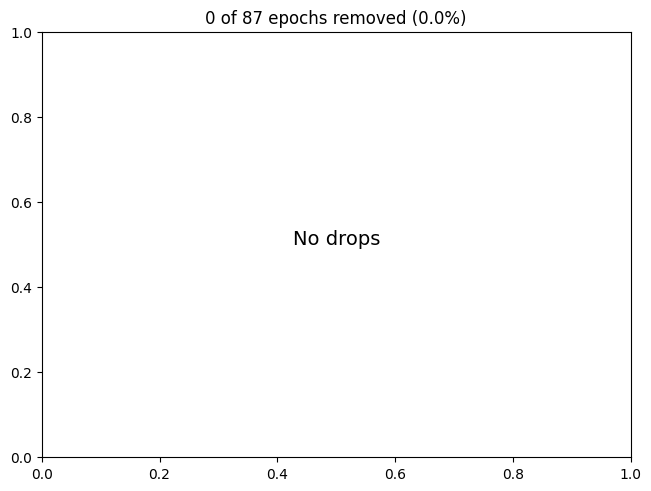

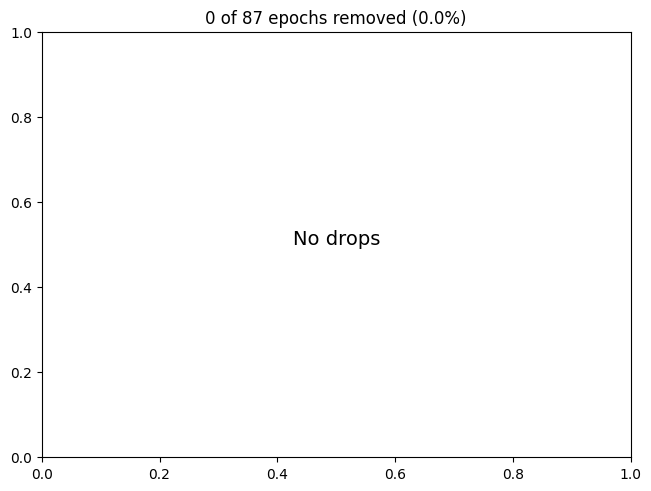

In [22]:
test_epochs.plot_drop_log()